<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/S08_Attention_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нахождение лекарств, заболеваний и взаимосвязи между ними

BioBERT - трансформер, предобученный на корпусе медицинских текстов.
Поставим два замечательных пакета для работы с трансформерами

In [6]:
!pip install -q transformers
!pip install -q simpletransformers

Загрузим данные с гитхаба. Это данные датасета BC5CDR - текстового датасета, в котором проаннотированы слова/словосочетания, относящиеся к химическим веществам, заболеваниям и взаимосвязи между ними.

Задачей является уметь предсказывать эти слова (помечая их тегами I и B,         [подробнее](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) )

In [ ]:
# The IOB (short for inside, outside, beginning) is a common tagging format for tagging tokens.

# I- prefix before a tag indicates that the tag is inside a chunk.
# B- prefix before a tag indicates that the tag is the beginning of a chunk.
# An O tag indicates that a token belongs to no chunk (outside).

In [7]:
# https://github.com/shreyashub/BioFLAIR/blob/master/data/ner/bc5cdr

import urllib.request
from pathlib import Path

def download_file(url, output_file):
  Path(output_file).parent.mkdir(parents=True, exist_ok=True)
  urllib.request.urlretrieve (url, output_file)

download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/train.txt', '/content/data/train.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/test.txt', '/content/data/test.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/dev.txt', '/content/data/dev.txt')

И напишем код для их перформатирования

In [8]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['words', 'pos', 'chunk', 'labels'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

In [9]:
train_df = read_conll('/content/data/train.txt')
test_df = read_conll('/content/data/test.txt')
dev_df = read_conll('/content/data/dev.txt')
train_df.head(100)

,words,pos,chunk,labels,sentence_id
2,Naloxone,PROPN,O,I-Entity,1
3,reverses,VERB,O,O,1
4,the,DET,O,O,1
5,antihypertensive,ADJ,O,O,1
6,effect,NOUN,O,O,1
...,...,...,...,...,...
102,not,ADV,O,O,6
103,influence,VERB,O,O,6
104,stereoselective,ADJ,O,O,6
105,binding,NOUN,O,O,6


In [ ]:
# Universal POS tags

# ADJ: adjective
# ADP: adposition
# ADV: adverb
# AUX: auxiliary
# CCONJ: coordinating conjunction
# DET: determiner
# INTJ: interjection
# NOUN: noun
# NUM: numeral
# PART: particle
# PRON: pronoun
# PROPN: proper noun
# PUNCT: punctuation
# SCONJ: subordinating conjunction
# SYM: symbol
# VERB: verb
# X: other

Посмотрим, сколько у нас данных

In [10]:
data = [[train_df['sentence_id'].nunique(), test_df['sentence_id'].nunique(), dev_df['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,3942,4139,3949


## Обучение модели

Зададим аргументы для обучения нашей модели

In [11]:
# Set model arguments
# https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model

train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 10,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs/',
    'best_model_dir': '/outputs/best_model/',
    'evaluate_during_training': True,
}

In [12]:
custom_labels = list(train_df['labels'].unique())
print(custom_labels)

['I-Entity', 'O', 'B-Entity']


Загрузим предобученную BioBert модель

In [13]:
from simpletransformers.ner import NERModel
from transformers import AutoTokenizer
import pandas as pd
import logging

transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the bio BERT pre-trained model.
model = NERModel('bert', 'dmis-lab/biobert-v1.1', labels=custom_labels, args=train_args)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

И дообучим эту модель

In [14]:
# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping


# Дополните код
model.train_model(train_df,
                  eval_data=dev_df,
                  args=dict(num_train_epochs=1))

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/42 [00:00<?, ?it/s]

Посмотрим, что эта модель "умеет"

In [15]:
sample = test_df[test_df.sentence_id == 10].words.str.cat(sep=' ')
print(sample)

After a single oral dose of 4 mg / kg indomethacin ( IDM ) to sodium and volume depleted rats plasma renin activity ( PRA ) and systolic blood pressure fell significantly within four hours .


In [16]:
samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'After': 'O'}
{'a': 'O'}
{'single': 'O'}
{'oral': 'O'}
{'dose': 'O'}
{'of': 'O'}
{'4': 'O'}
{'mg': 'O'}
{'/': 'O'}
{'kg': 'O'}
{'indomethacin': 'I-Entity'}
{'(': 'O'}
{'IDM': 'I-Entity'}
{')': 'O'}
{'to': 'O'}
{'sodium': 'O'}
{'and': 'O'}
{'volume': 'I-Entity'}
{'depleted': 'O'}
{'rats': 'O'}
{'plasma': 'O'}
{'renin': 'O'}
{'activity': 'O'}
{'(': 'O'}
{'PRA': 'O'}
{')': 'O'}
{'and': 'O'}
{'systolic': 'O'}
{'blood': 'O'}
{'pressure': 'O'}
{'fell': 'O'}
{'significantly': 'O'}
{'within': 'O'}
{'four': 'O'}
{'hours': 'O'}
{'.': 'O'}


Видим, что модель правильно указала нам слова, относящиеся к химическим веществам

Попробуем предложение "от себя"

In [17]:
words = "Paracetamol can cause drug-induced hepatitis"

In [19]:
samples = [words]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'Paracetamol': 'I-Entity'}
{'can': 'O'}
{'cause': 'O'}
{'drug-induced': 'O'}
{'hepatitis': 'I-Entity'}


In [20]:
# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping


# Дополните код
model.train_model(train_df,
                  eval_data=dev_df,
                  args=dict(num_train_epochs=10))

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/42 [00:00<?, ?it/s]

In [21]:
words = "Paracetamol can cause drug-induced hepatitis"

samples = [words]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'Paracetamol': 'I-Entity'}
{'can': 'O'}
{'cause': 'O'}
{'drug-induced': 'B-Entity'}
{'hepatitis': 'I-Entity'}


In [22]:
sample = test_df[test_df.sentence_id == 10].words.str.cat(sep=' ')
print(sample)


After a single oral dose of 4 mg / kg indomethacin ( IDM ) to sodium and volume depleted rats plasma renin activity ( PRA ) and systolic blood pressure fell significantly within four hours .


In [23]:

samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'After': 'O'}
{'a': 'O'}
{'single': 'O'}
{'oral': 'O'}
{'dose': 'O'}
{'of': 'O'}
{'4': 'O'}
{'mg': 'O'}
{'/': 'O'}
{'kg': 'O'}
{'indomethacin': 'I-Entity'}
{'(': 'O'}
{'IDM': 'I-Entity'}
{')': 'O'}
{'to': 'O'}
{'sodium': 'I-Entity'}
{'and': 'O'}
{'volume': 'O'}
{'depleted': 'O'}
{'rats': 'O'}
{'plasma': 'O'}
{'renin': 'O'}
{'activity': 'O'}
{'(': 'O'}
{'PRA': 'O'}
{')': 'O'}
{'and': 'O'}
{'systolic': 'O'}
{'blood': 'O'}
{'pressure': 'O'}
{'fell': 'O'}
{'significantly': 'O'}
{'within': 'O'}
{'four': 'O'}
{'hours': 'O'}
{'.': 'O'}


Работает!

In [ ]:
model.model

# Получаем представление статей

При помощи трансформеров можно также получать представления целых текстов и далее анализировать их похожесть.



## Кластеризуем статьи по названию

Напишем код для скачивания с PubMed статей по заданным темам и далее визуально кластеризуем названия полученных статей

In [24]:
from simpletransformers.language_representation import RepresentationModel

sentences = ['''
Wallerian degeneration, the progressive disintegration of distal axons and
myelin that occurs after peripheral nerve injury, is essential for creating a
permissive microenvironment for nerve regeneration, and involves cytoskeletal
reconstruction. However, it is unclear whether microtubule dynamics play a role
in this process. To address this, we treated cultured sciatic nerve explants, an
in vitro model of Wallerian degeneration, with the microtubule-targeting agents
paclitaxel and nocodazole. We found that paclitaxel-induced microtubule
stabilization promoted axon and myelin degeneration and Schwann cell
dedifferentiation, whereas nocodazole-induced microtubule destabilization
inhibited these processes. Evaluation of an in vivo model of peripheral nerve
injury showed that treatment with paclitaxel or nocodazole accelerated or
attenuated axonal regeneration, as well as functional recovery of nerve
conduction and target muscle and motor behavior, respectively. These results
suggest that microtubule dynamics participate in peripheral nerve regeneration
after injury by affecting Wallerian degeneration.
''',
'''Clinical Evaluation of the Rapid STANDARD Q COVID-19 Ag Test for the Screening of Severe Acute Respiratory Syndrome Coronavirus 2.''']
model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=False
    )

word_vectors = model.encode_sentences(sentences, combine_strategy="mean")
assert word_vectors.shape == (2, 768) # one sentence embedding per sentence

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
word_vectors

array([[ 0.21164674, -0.07588737, -0.16311459, ...,  0.10548719,
        -0.03305141, -0.23099221],
       [ 0.07401571, -0.26707876, -0.04237285, ...,  0.08607654,
         0.08473048, -0.2760928 ]], dtype=float32)

Скачаем названия статей

In [26]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.3 MB/s eta 0:00:00


In [27]:
from Bio import Entrez

In [28]:
def search_papers(query, retmax=200, sort='relevance', has_summary=False):
    Entrez.email = 'pdd@kodomo.fbb.msu.ru'
    handle = Entrez.esearch(db='pubmed',
                            sort=sort,
                            retmax=str(retmax),
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

def search_titles(ids):
    res = Entrez.esummary(db="pubmed", id=",".join(ids), retmode='xml')
    records = Entrez.parse(res)
    return [rec['Title'] for rec in records]

def retrieve_titles(query):
    results = search_papers(query)
    ids = results['IdList']
    return search_titles(ids)

In [29]:
topics = ['covid19',
          'alphafold2',
          'schizophrenia',
          'drug design',
          'longevity',
          'personalized medicine',
          'cancer',
          'nanotechnology',
          'neural networks',
          'bitcoin']

topics2titles = {}
for t in topics:
  print(t)
  titles = retrieve_titles(t)
  topics2titles[t] = titles

covid19
alphafold2
schizophrenia
drug design
longevity
personalized medicine
cancer
nanotechnology
neural networks
bitcoin


## Кластеризуем статьи по названию


In [30]:
all_titles = sum(topics2titles.values(), [])

In [31]:
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=True
    )
word_vectors = model.encode_sentences(all_titles, combine_strategy="mean")
assert word_vectors.shape == (len(all_titles), 768) # one sentence embedding per sentence

In [32]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.2 MB/s eta 0:00:00


In [33]:
from umap import UMAP

In [34]:
umap_trans = UMAP(n_components = 2, metric="cosine")

In [36]:
X = umap_trans.fit_transform(word_vectors)

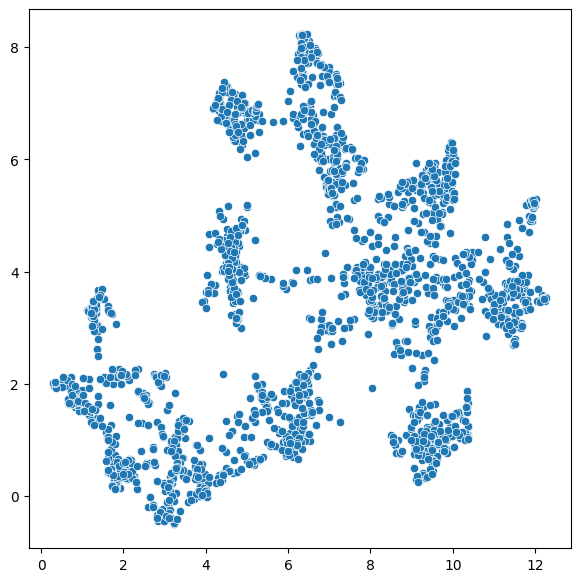

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.show()

In [38]:
import pandas as pd

topics = []
for t, papers in topics2titles.items():
    for p in papers:
        topics.append(t)

df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "topic": topics})

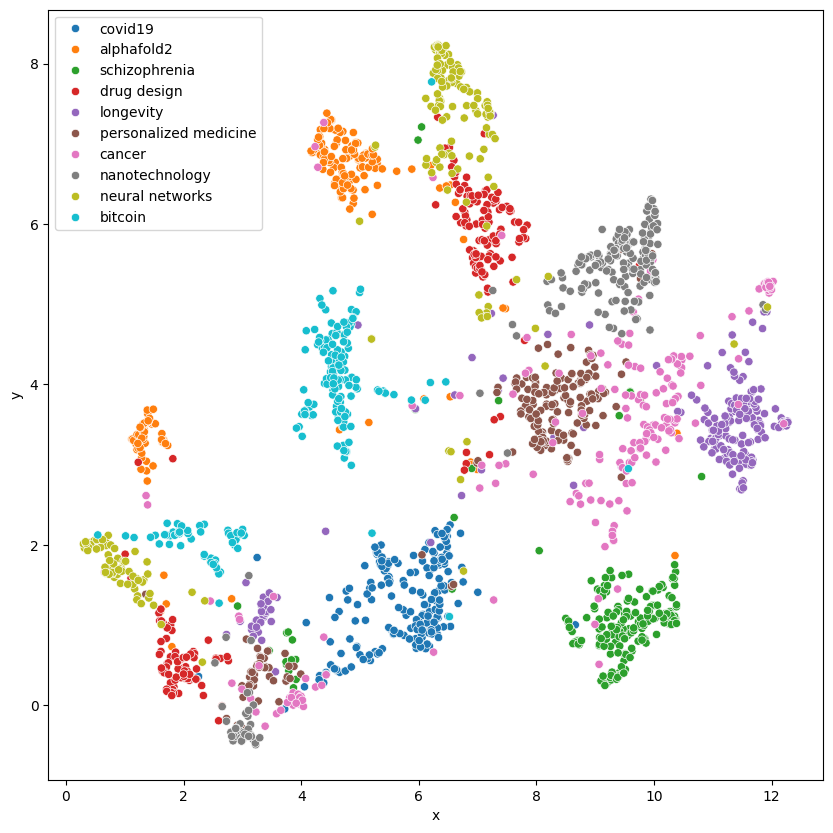

In [39]:
# Дополните код: замените ??
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df,
                x='x', y='y', hue="topic", palette=sns.color_palette("tab10"))
plt.legend()
plt.show()

## Кластеризуем статьи по абстракту


In [40]:
def search_papers(query, retmax=200, sort='relevance'):
    Entrez.email = 'pdd@kodomo.fbb.msu.ru'
    handle = Entrez.esearch(db='pubmed',
                            sort=sort,
                            retmax=str(retmax),
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

def check_abstract(ids):
    res = Entrez.esummary(db="pubmed", id=",".join(ids), retmode='xml')
    records = Entrez.parse(res)

    return [rec['Id'] for rec in records if rec['HasAbstract']] # Проверяем что Abstract есть


def retrieve_abstracts(query, has_abstract=False, retmax=200, sort='relevance'):
    results = search_papers(query, retmax, sort)
    ids = results['IdList']
    ids = check_abstract(ids)

    records = Entrez.read(Entrez.efetch(db="pubmed", id =','.join(ids), rettype="xml"))['PubmedArticle']
    abstracts = []
    for rec in records:
        try: # if HasAbstract==True but no abstract provided
          abs = rec['MedlineCitation']['Article']['Abstract']['AbstractText']
          abs = " ".join(abs)
          abstracts.append(abs)
        except KeyError:
          continue

    return abstracts

In [ ]:
res = retrieve_abstracts("covid19")

In [41]:
topics = ['covid19',
          'alphafold2',
          'schizophrenia',
          'drug design',
          'longevity',
          'personalized medicine',
          'cancer',
          'nanotechnology',
          'neural networks',
          'bitcoin']

topics2abstracts = {}
for t in topics:
  print(t)
  abstracts = retrieve_abstracts(t)
  topics2abstracts[t] = abstracts

covid19
alphafold2
schizophrenia
drug design
longevity
personalized medicine
cancer
nanotechnology
neural networks
bitcoin


In [42]:
all_abstracts = sum(topics2abstracts.values(), [])

In [43]:
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=True
    )
word_vectors = model.encode_sentences(all_abstracts, combine_strategy="mean")
assert word_vectors.shape == (len(all_abstracts), 768) # one sentence embedding per sentence

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [45]:
umap_trans = UMAP(n_components = 2, metric="cosine")
X = umap_trans.fit_transform(word_vectors)

In [46]:
topics = []
for t, papers in topics2abstracts.items():
    for p in papers:
        topics.append(t)

df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "topic": topics})

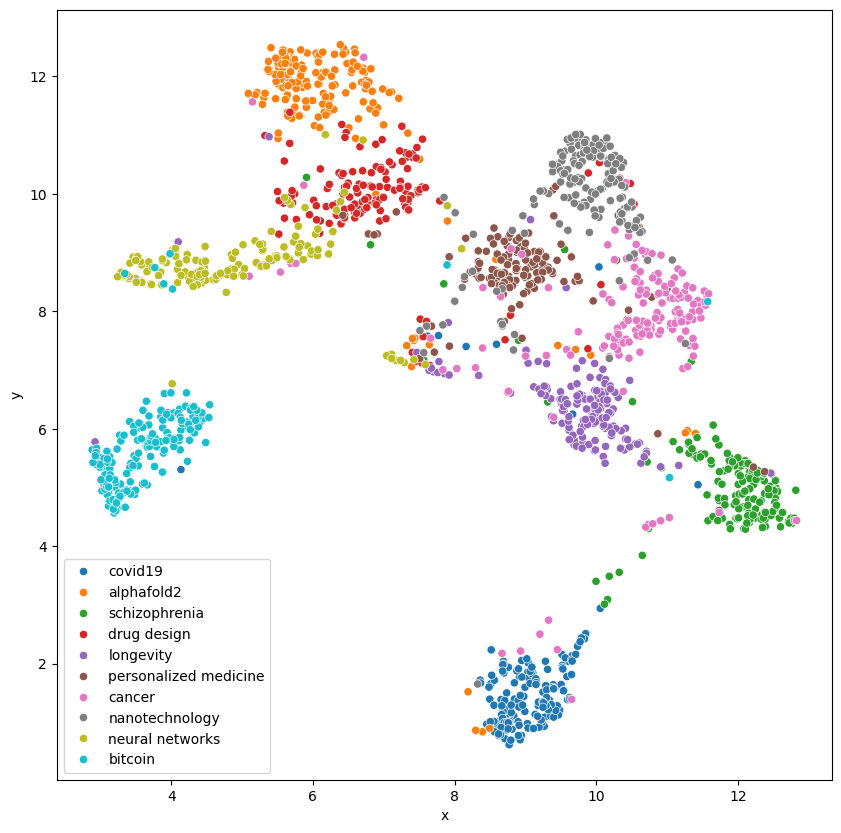

In [48]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue="topic", palette=sns.color_palette("tab10"))
plt.legend()
plt.show()

# Self-supervised сегментация при помощи DINO

In [ ]:
!git clone https://github.com/facebookresearch/dino

Cloning into 'dino'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 168 (delta 10), reused 15 (delta 5), pack-reused 144
Receiving objects: 100% (168/168), 24.47 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
!python dino/visualize_attention.py

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth
100% 82.7M/82.7M [00:08<00:00, 9.67MB/s]
Please use the `--image_path` argument to indicate the path of the image you wish to visualize.
Since no image path have been provided, we take the first image in our paper.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch

In [ ]:
from IPython.display import Image


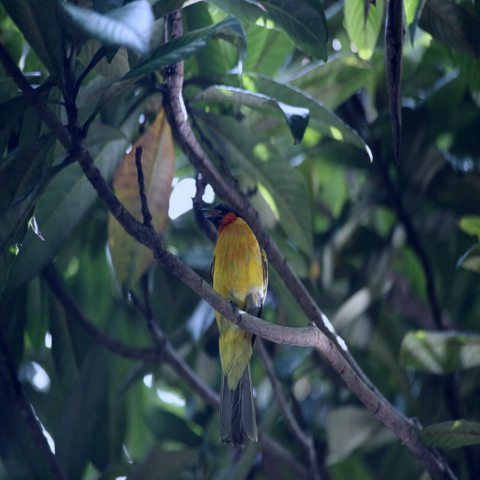

In [ ]:

Image(filename=f"./img.png" )

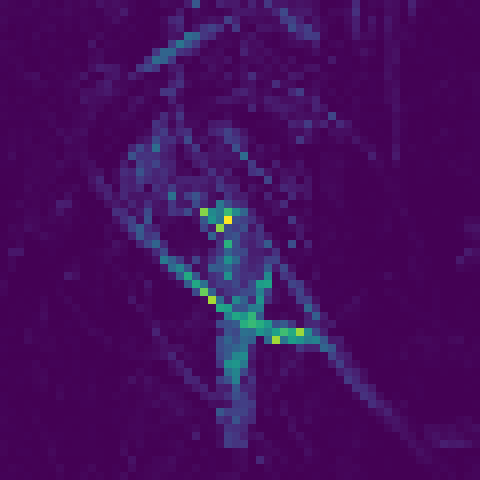

In [ ]:

Image(filename=f"./attn-head0.png")

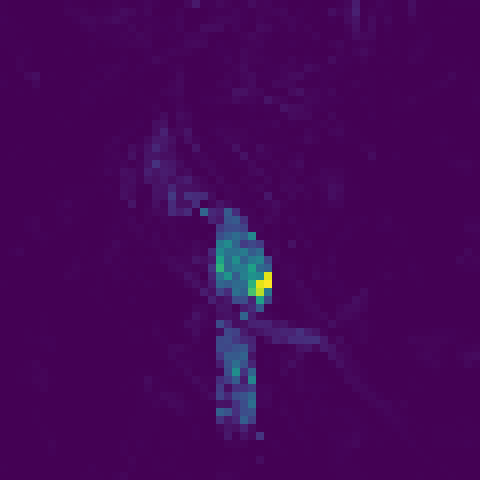

In [ ]:

Image(filename=f"./attn-head1.png")

Видим, что действительно исходное изображение сегментируется.

Можем использовать нейросеть чтобы натренировать лучшие распознаватели птиц/растений и т.д.

А что если подать на вход медицинское изображение, похожего на которое вообще не было в датасете?

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/lung.jpeg

--2021-12-15 19:01:43--  https://kodomo.fbb.msu.ru/FBB/year_20/ml/lung.jpeg
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116816 (114K) [image/jpeg]
Saving to: ‘lung.jpeg’

lung.jpeg           100%[===================>] 114.08K   133KB/s    in 0.9s    

2021-12-15 19:01:46 (133 KB/s) - ‘lung.jpeg’ saved [116816/116816]



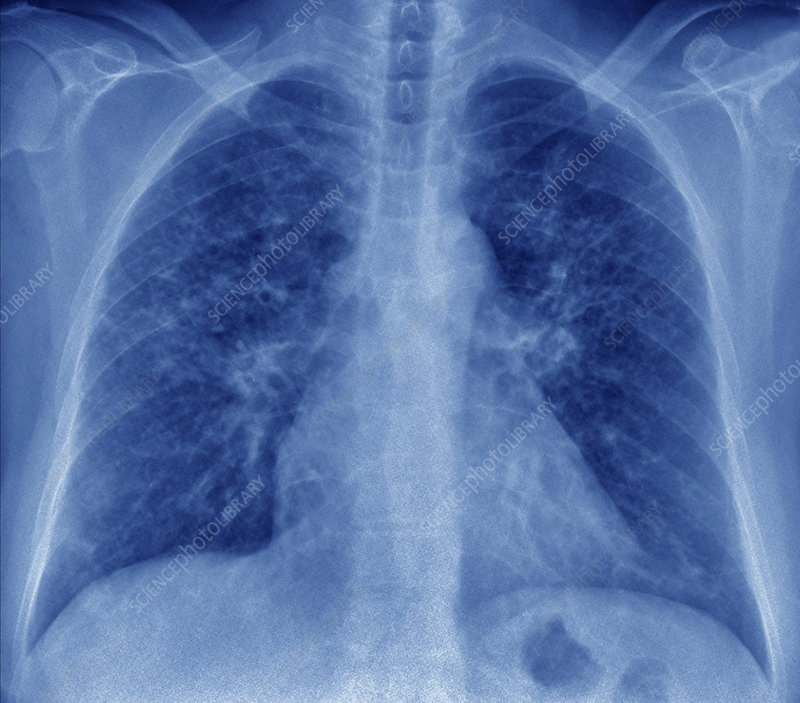

In [ ]:
Image(filename="lung.jpeg")

In [ ]:
!python dino/visualize_attention.py --image_path lung.jpeg

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior

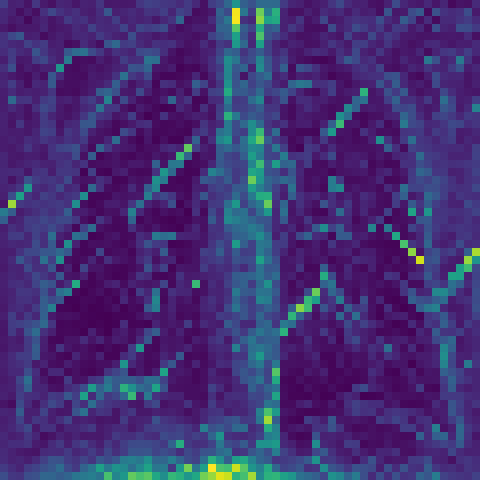

In [ ]:
Image(filename=f"./attn-head1.png")

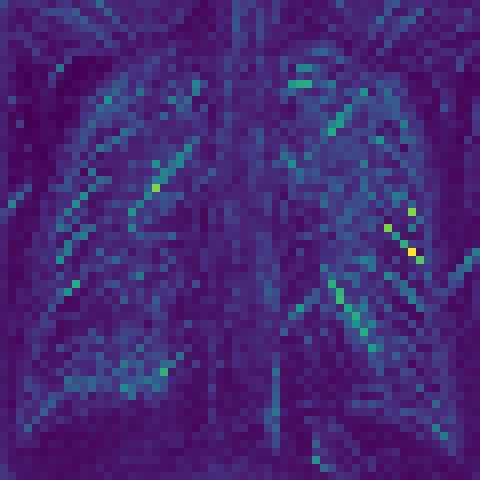

In [ ]:
Image(filename=f"./attn-head2.png")

Внезапно - сегментация тоже хорошая.

Мы можем использовать эту сеть для доменов, которые она в принципе не видела!

# AlphaFold2

Ну и, наконец, AlphaFold2.

Воспользуемся ноутбуком, выложенным в публичный доступ Сергеем Овчинниковым - [ссылка](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)

В этом ноутбуке все полностью автоматизировано

## Победы AlphaFold2

Не включайте template search, иначе совсем нечестно

In [ ]:
seq1 = "TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEIKTFTVTE"
seq2 = "TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE"

In [ ]:
for ind, (s1, s2) in enumerate(zip(seq1, seq2) ):
  if s1 != s2:
    print(f"Differ: {s1}{ind}{s2}")

Differ: L19A
Differ: I29F
Differ: L44Y


Должно получиться как в [этой статье](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2779201/)

Конечно, можно заметить, что при обучении модель видела структуры, выложенные в PDB. Но у AlphaFold бывают успехи и на структурах, которые еще не были опубликованы и при этом сложны.

## Поражения AlphaFold2

Промоделируйте следующую последовательность:



In [ ]:
seq = '''MDQNNSLPPYAQGLASPQGAMTPGIPIFSPMMPYGTGLTPQPIQNTNSLSILEEQQRQQQ
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQAVAAAAVQQSTSQQATQGTSGQAPQ
LFHSQTLTTAPLPGTTPLYPSPMTPMTPITPATPASESSGIVPQLQNIVSTVNLGCKLDL
KTIALRARNAEYNPKRFAAVIMRIREPRTTALIFSSGKMVCTGAKSEEQSRLAARKYARV
VQKLGFPAKFLDFKIQNMVGSCDVKFPIRLEGLVLTHQQFSSYEPELFPGLIYRMIKPRI
VLLIFVSGKVVLTGAKVRAEIYEAFENIYPILKGFRKTT'''

Сравните с тем, что [должно](https://twitter.com/PappulabWashU/status/1418332465740066816/photo/2) получиться

# *Получаем представления белков

Кроме этого, есть модели, которые self-supervised натренированы на биологических последовательностях.

Самая известная из них, разумеется, AlphaFold2, которая тоже внутри себя использует натренированную таким образом подсеть.

Однако есть и более "простые" модели, например, модель от FacebookAI - ESM1b

In [ ]:
!pip install fair-esm

In [ ]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm", "esm1b_t33_650M_UR50S")

In [ ]:
device = torch.device("cuda")

In [ ]:
import torch
import esm

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.to(device)
batch_converter = alphabet.get_batch_converter()

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEEKALTARQQEVFDLIRDHISQTGMPPTRAEIAQ"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, (_, seq) in enumerate(data):
        sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0).cpu() )


In [ ]:
print(sequence_representations)

In [ ]:
print(sequence_representations[0].shape)

Точно так же, при помощи полученных представлений, белки можно сравнивать.
Можно использовать полученные представления

Можем взять несколько семейств белков и посмотреть, разделятся ли они в латентном пространстве.

А можно попытаться, например, предсказать температуру плавления белка.

Возьмем датасет, препроцессированный при помощи пакета DeepChem

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/protein_melt.fasta

In [ ]:
!pip install BioPython

In [ ]:
from Bio import SeqIO

In [ ]:
X = []
y = []
for seq in SeqIO.parse("protein_melt.fasta", "fasta"):
    X.append( (seq.id, str(seq.seq)))
    y.append(float(seq.description.split("melt:")[-1]))


In [ ]:
X_repr = []

In [ ]:
!nvidia-smi

In [ ]:
step = 1
for ind in range(0, len(X), step):
  print(ind)
  batch_labels, batch_strs, batch_tokens = batch_converter(X[ind:ind+step])

  # Extract per-residue representations (on CPU)
  with torch.no_grad():
      results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
      token_representations = results["representations"][33]
      # Generate per-sequence representations via averaging
      # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
      sequence_representations = []
      for i, (_, seq) in enumerate(X[ind:ind+step]):
          sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0).cpu())
      X_repr.append(sequence_representations)


In [ ]:
X_embed = [x[0].unsqueeze(0) for x in X_repr]

In [ ]:
X_embed = torch.cat(X_embed, dim=0).numpy()

Есть два варианта разбить датасет. Какой правильнее? Указание - посмотрите на идентификаторы последовательностей  

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_embed, y)

In [ ]:
val_start = int(X_embed.shape[0] * (1 - 0.8))
X_train, X_test, y_train, y_test = X_embed[:val_start], X_embed[val_start:], y[:val_start], y[val_start:]

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:
model = SGDRegressor().fit(X_train, y_train)
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"MAE: {mae}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor